In [64]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import shapiro, levene, f_oneway, kruskal, mannwhitneyu, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [65]:
df = pd.read_csv('dataset_final_cleaned.csv')
df.columns = df.columns.str.strip().str.lower()

# Гипотеза: Игры с ачивками vs игры без ачивоку

$H_0$: Игры независимо от ачивок имеют одинаковый рейтинг.

$H_1$: Игры с ачивками имеют более высокий рейтинг, чем игры без ачивок.

In [66]:
df['has_achievements'] = df['achievements_count'] > 0
group_a = df[df['has_achievements'] == False]['weighted_rating'].values
group_b = df[df['has_achievements'] == True]['weighted_rating'].values

print(f"Игры без достижений: {len(group_a)}")
print(f"Игры с достижениями: {len(group_b)}")

Игры без достижений: 607
Игры с достижениями: 1811


Мы видим, что наши выборки имеют достаточно большое количество данных, поэтому из распределения будут стремится к нормальным по ЦПТ. Для того, чтобы в этом убедится, построим Q-Q plot-ы для них.

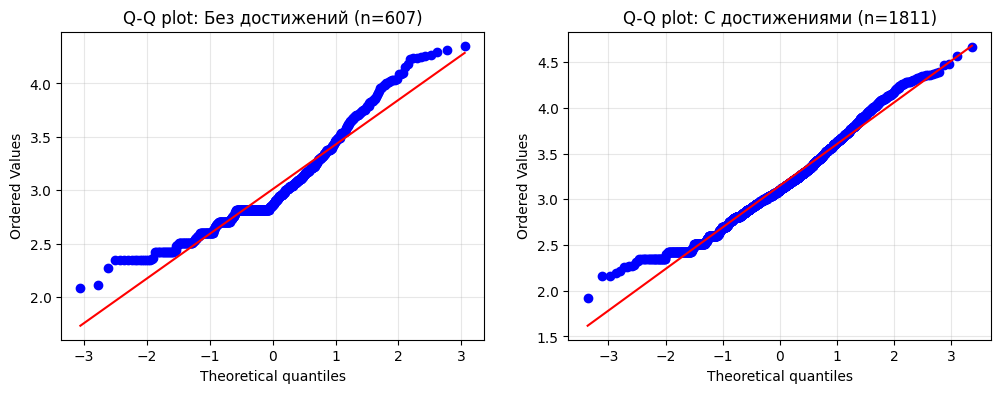

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

stats.probplot(group_a, dist="norm", plot=axes[0])
axes[0].set_title(f'Q-Q plot: Без достижений (n={len(group_a)})')
axes[0].grid(True, alpha=0.3)

stats.probplot(group_b, dist="norm", plot=axes[1])
axes[1].set_title(f'Q-Q plot: С достижениями (n={len(group_b)})')
axes[1].grid(True, alpha=0.3)

На данных графиках мы видим, что наше распределение будет близко к нормальному (а также вилим, что чем больше n, тем лучше работает ЦПТ).

Теперь проверим равенство дисперсий при помощи теста Левена.

In [68]:
_, p_levene = stats.levene(group_a, group_b)
print(f"p-value = {p_levene:.6f}")

p-value = 0.014338


Поскольку p-value меньше 0.05, то дисперсии различаются. В завершение предварительного анализа выборок проверим их коэффициент вариации.

In [69]:
cv_a = (group_a.std() / group_a.mean()) * 100
cv_b = (group_b.std() / group_b.mean()) * 100

print(f"Группа A: CV = {cv_a:.2f}%")
print(f"Группа B: CV = {cv_b:.2f}%")

Группа A: CV = 14.32%
Группа B: CV = 14.56%


Значение CV достаточно маленькое, чтобы наши результаты были не случаными.

В результате анализа выборок мы понимаем, что наши группы являются не сбаланнсированными, но с нормальным распределением и не равными дисперсиями. Это говорит нам о том, что мы можем использовать т-тест Велча, поскольку он как раз придуман для того, чтобы работать с несбаланнсированными группами, у которых различные дисперсии.

In [70]:
t_stat, p_welch = stats.ttest_ind(group_a, group_b, equal_var=False)
print(f"t-статистика: {t_stat:.4f}")
print(f"p-value: {p_welch:.6f}")

t-статистика: -6.8178
p-value: 0.000000


Поскольку p-value < 0.05, то есть статистические раличая между выборками, следовательно, мы отвергаем нулевую гипотезу. Узнаем насколько сильно раличаются наши выборки на практике.

In [71]:
mean_a = np.mean(group_a)
mean_b = np.mean(group_b)

print(f"Без достижений: mean={mean_a:.4f}")
print(f"С достижениями: mean={mean_b:.4f}")
print(f"Разница средних: {mean_a - mean_b:.4f}")

Без достижений: mean=3.0085
С достижениями: mean=3.1487
Разница средних: -0.1401


Разница является достаточно ощутимой для рейтинга, поэтому мы получаем, что игр, в которых есть ачивки, набирают более высокий рейтинг, нежели игры, которые не имеют системы достижений.

# Гипотеза: "Золотая зона" - ачивки от 81 до 100

$H_0$: У всех игр с ачивками средний рейтинг одинаковый

$H_1$: У игр с ачивками в количестве 81-100 рейтинг выше, чем у остальных игр

In [72]:
df['is_golden_zone'] = (df['achievements_count'] >= 81) & (df['achievements_count'] <= 100)


group_a = df[df['is_golden_zone'] == True]['weighted_rating'].values
group_b = df[(df['is_golden_zone'] == False) & (df['achievements_count']>0)]['weighted_rating'].values

print(f"Золотая зона (81-500 достижений): {len(group_a)}")
print(f"Все остальные игры: {len(group_b)}")

Золотая зона (81-500 достижений): 133
Все остальные игры: 1678


Наши группы получились сильно несбаланнсироваными, однако их количество больше 30, что говорит о том, что по ЦПТ они стремятся к нормальному распределению. Проверим это по Q-Q plot.

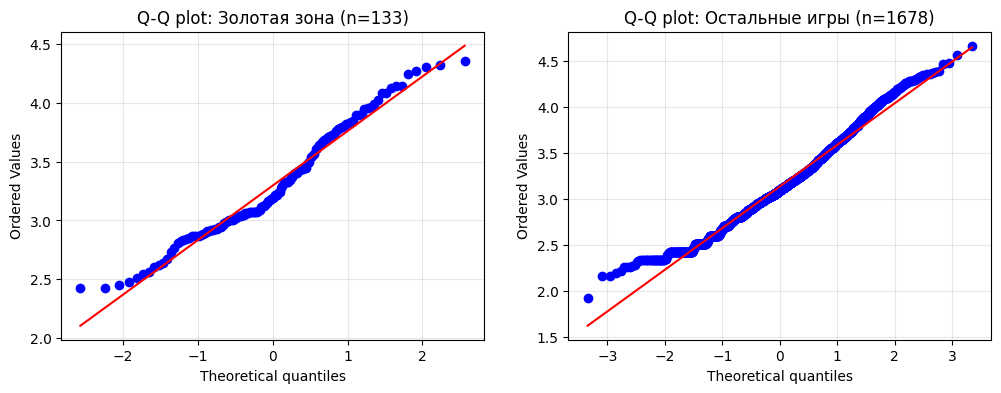

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

stats.probplot(group_a, dist="norm", plot=axes[0])
axes[0].set_title(f'Q-Q plot: Золотая зона (n={len(group_a)})')
axes[0].grid(True, alpha=0.3)

stats.probplot(group_b, dist="norm", plot=axes[1])
axes[1].set_title(f'Q-Q plot: Остальные игры (n={len(group_b)})')
axes[1].grid(True, alpha=0.3)

В целом, мы наблюдаем хорошие концы, а значит, что наши распределения являются нормальными. Проверим их коэффицент вариации.

In [74]:
cv_a = (group_a.std() / group_a.mean()) * 100
cv_b = (group_b.std() / group_b.mean()) * 100

print(f"Группа A: CV = {cv_a:.2f}%")
print(f"Группа B: CV = {cv_b:.2f}%")

Группа A: CV = 14.05%
Группа B: CV = 14.54%


Мы видим маленькие значения коэффициента, значит, полученные нами результаты будут не случаными.

В завершение предварительного анализа проверим равенство дисперсий при помощи теста Левена.

In [75]:
_, p_levene = stats.levene(group_a, group_b)
print(f"p-value = {p_levene:.6f}")

p-value = 0.439220


Мы видим, что p-value > 0.05, значит, наши дисперсии равны.

На первый взгляд кажется, что нормальное распределение и равенство дисперсий приводит нас к t-тесту, но этот тест чувствителен к несбалансированности групп, поэтому мы снова воспольземся т-тестов Велча.

In [76]:
t_stat, p_welch = stats.ttest_ind(group_a, group_b, equal_var=False)
print(f"t-статистика: {t_stat:.4f}")
print(f"p-value: {p_welch:.6f}")

t-статистика: 3.7814
p-value: 0.000223


Поскольку p-value < 0.05, то есть статистические раличая между выборками, следовательно, мы отвергаем нулевую гипотезу. Узнаем насколько сильно раличаются наши выборки на практике.

In [77]:
mean_a = np.mean(group_a)
mean_b = np.mean(group_b)

print(f"Золотая зона: mean={mean_a:.4f}")
print(f"Остальные игры: mean={mean_b:.4f}")
print(f"Разница средних: {mean_a - mean_b:.4f}")

Золотая зона: mean=3.2952
Остальные игры: mean=3.1371
Разница средних: 0.1581


0.15 не супер большая, но ощутимая разница в рейтингах игр. Исходя из этого, мы понимаем, что "Золотая зона" существует, и в ней игры имеют более высокий средний рейтинг.